In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [2]:
data_path = Path(__name__).resolve().parent.parent / "data/item_1a.csv"
df = pd.read_csv(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cik               110 non-null    int64 
 1   company           110 non-null    object
 2   filing_date       110 non-null    object
 3   period_of_report  110 non-null    object
 4   item_1A           110 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.4+ KB


In [3]:
df.head(20)

,cik,company,filing_date,period_of_report,item_1A
0,1000228,HENRY SCHEIN INC,2022-02-15,2021-12-25,ITEM 1A. Risk Factors\nOur business operations...
1,1000697,WATERS CORP /DE/,2022-02-24,2021-12-31,Item 1A:\nRisk Factors\nThe Company is subject...
2,1002910,AMEREN CORP,2022-02-23,2021-12-31,ITEM 1A.RISK FACTORS\nInvestors should review ...
3,1002910,AMEREN CORP,2023-02-22,2022-12-31,ITEM 1A.RISK FACTORS\nInvestors should review ...
4,1004980,PG&E Corp,2022-02-10,2021-12-31,ITEM 1A. RISK FACTORS\nPG&E Corporation’s and ...
5,100517,"United Airlines Holdings, Inc.",2022-02-18,2021-12-31,ITEM 1A. RISK FACTORS.\nAny of the risks and u...
6,100885,UNION PACIFIC CORP,2022-02-04,2021-12-31,Item 1A. Risk Factors\nThe following discussio...
7,1013871,"NRG ENERGY, INC.",2022-02-24,2021-12-31,Item 1A - Risk Factors\nNRG's risk factors are...
8,1014473,VERISIGN INC/CA,2022-02-18,2021-12-31,ITEM 1A. RISK FACTORS\nPlease carefully consid...
9,101829,RAYTHEON TECHNOLOGIES CORP,2022-02-11,2021-12-31,"ITEM 1A. RISK FACTORS\nOur business, operating..."


In [4]:
#change item_1A column to risk_factor_text
df.rename({"item_1A":"risk_factor_text"}, axis=1, inplace=True)

In [5]:
#check for duplicates in text column
sum(df.duplicated(subset=["risk_factor_text"], keep=False))

#no duplicates so far

0

In [6]:
#check if some companies do not have risk factors submitted. 
# S&P companies might probably have because they might be large companies 

# MAIN POINT
# (reason why S&P companies were chosen for this project)

In [7]:
df['risk_factor_text'].apply(lambda x: len(x.split())).min()

# The minimum number of words for an example is 3258.

#MAIN POINT
# This means that the text contains risk factors

3258

In [8]:
def remove_item_1a_heading(text: str) -> str:
    pattern = r'^(?:item\s*1a\s*[\.\-\|:]*\s*[\.\-\|:]*\s*risk\s*factors[\.\s]*\n*)+'
    return re.sub(pattern, '', text, flags=re.IGNORECASE).lstrip()

#applying the regex
df["regexed_text"] = df["risk_factor_text"].apply(remove_item_1a_heading)

In [9]:
#all of the risk_factor_text start with item 
sum(df['risk_factor_text'].str.lower().str.startswith("item"))

110

In [10]:
#GOOD POINT
#none of the regexed text starts with Item which is goo
sum(df['regexed_text'].str.startswith("Item"))

0

In [11]:
#word count
df['word_count'] = df['regexed_text'].apply(lambda x: len(x.split()))

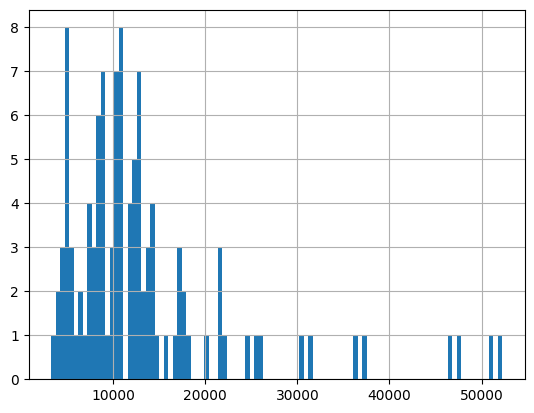

In [12]:
df['word_count'].hist(bins=100)
plt.show()

#the distribution of the number of words used

In [13]:
def merge_wrapped_headers(text: str) -> str:
    lines = text.splitlines()
    merged = []
    i = 0

    while i < len(lines):
        line = lines[i].strip()

        # header-like line
        if (
            line
            and len(line) < 80
            and not line.endswith('.')
            and line.upper() == line or line.istitle()
        ):
            # check if next line is also header-like
            if i + 1 < len(lines):
                next_line = lines[i + 1].strip()
                if (
                    next_line
                    and len(next_line) < 80
                    and not next_line.endswith('.')
                ):
                    merged.append(f"{line} {next_line}")
                    i += 2
                    continue

        merged.append(lines[i])
        i += 1

    return "\n".join(merged)

HEADER_PATTERN = re.compile(
    r'^(?:[A-Z][A-Z\s,&\-]{5,}|[A-Z][a-z]+(?:[\s,&\-][A-Za-z]+){1,})$'
)


In [14]:
def extract_risk_sections(text: str):
    text = merge_wrapped_headers(text)
    lines = text.splitlines()

    sections = []
    current_header = None
    current_body = []

    for line in lines:
        line = line.strip()

        if HEADER_PATTERN.match(line):
            if current_header and current_body:
                sections.append(
                    (current_header, " ".join(current_body).strip())
                )
                current_body = []
            current_header = line
        else:
            if current_header:
                current_body.append(line)

    if current_header and current_body:
        sections.append(
            (current_header, " ".join(current_body).strip())
        )

    return sections


In [ ]:
def explode_risk_sections(df, text_col="regexed_text"):
    rows = []

    for _, row in df.iterrows():
        sections = extract_risk_sections(row[text_col])

        for header, text in sections:
            new_row = row.to_dict()
            new_row["risk_header"] = header
            new_row["risk_text"] = text
            rows.append(new_row)

    return pd.DataFrame(rows)


In [16]:
df_risk = explode_risk_sections(df)
df_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cik               725 non-null    int64 
 1   company           725 non-null    object
 2   filing_date       725 non-null    object
 3   period_of_report  725 non-null    object
 4   risk_factor_text  725 non-null    object
 5   regexed_text      725 non-null    object
 6   word_count        725 non-null    int64 
 7   risk_header       725 non-null    object
 8   risk_text         725 non-null    object
dtypes: int64(2), object(7)
memory usage: 51.1+ KB


In [42]:
df_risk.head(5)

,cik,company,filing_date,period_of_report,risk_factor_text,regexed_text,word_count,risk_header,risk_text
0,1000228,HENRY SCHEIN INC,2022-02-15,2021-12-25,ITEM 1A. Risk Factors\nOur business operations...,Our business operations could be affected by f...,10324,COMPANY RISKS,"Our business, results of operations, cash flow..."
1,1000228,HENRY SCHEIN INC,2022-02-15,2021-12-25,ITEM 1A. Risk Factors\nOur business operations...,Our business operations could be affected by f...,10324,INDUSTRY RISKS,The health care products distribution industry...
2,1000228,HENRY SCHEIN INC,2022-02-15,2021-12-25,ITEM 1A. Risk Factors\nOur business operations...,Our business operations could be affected by f...,10324,MACRO ECONOMIC AND POLITICAL RISKS,Uncertain global macro-economic and political ...
3,1000228,HENRY SCHEIN INC,2022-02-15,2021-12-25,ITEM 1A. Risk Factors\nOur business operations...,Our business operations could be affected by f...,10324,REGULATORY AND LITIGATION RISKS,Failure to comply with existing and future reg...
4,1000228,HENRY SCHEIN INC,2022-02-15,2021-12-25,ITEM 1A. Risk Factors\nOur business operations...,Our business operations could be affected by f...,10324,GENERAL RISKS,Security risks generally associated with our i...


In [58]:
df_risk['risk_header'].value_counts().sort_values(ascending=True).head(50)

#manually review those risk that do not fall under actual risk

risk_header
COMPANY RISKS                                                                                                                                                                                     1
RISKS RELATED TO HUMAN CAPITAL MANAGEMENT                                                                                                                                                         1
RISKS RELATED TO MACROECONOMIC CONDITIONS                                                                                                                                                         1
REGULATORY AND LITIGATION RISKS                                                                                                                                                                   1
MACRO ECONOMIC AND POLITICAL RISKS                                                                                                                                                                1
Strategi

In [51]:
df_risk[df_risk['risk_header']=="Dollars in millions except per share amounts"]

,cik,company,filing_date,period_of_report,risk_factor_text,regexed_text,word_count,risk_header,risk_text
569,732717,AT&T INC.,2022-02-16,2021-12-31,ITEM 1A. RISK FACTORS\nIn addition to the othe...,In addition to the other information set forth...,8554,Dollars in millions except per share amounts,Macro-economic Factors: Adverse changes in the...
570,732717,AT&T INC.,2022-02-16,2021-12-31,ITEM 1A. RISK FACTORS\nIn addition to the othe...,In addition to the other information set forth...,8554,Dollars in millions except per share amounts,"The U.K. Financial Conduct Authority, which re..."
571,732717,AT&T INC.,2022-02-16,2021-12-31,ITEM 1A. RISK FACTORS\nIn addition to the othe...,In addition to the other information set forth...,8554,Dollars in millions except per share amounts,The COVID-19 pandemic and mitigation measures ...
572,732717,AT&T INC.,2022-02-16,2021-12-31,ITEM 1A. RISK FACTORS\nIn addition to the othe...,In addition to the other information set forth...,8554,Dollars in millions except per share amounts,Continuing growth in and the converging nature...
573,732717,AT&T INC.,2022-02-16,2021-12-31,ITEM 1A. RISK FACTORS\nIn addition to the othe...,In addition to the other information set forth...,8554,Dollars in millions except per share amounts,"Incidents leading to damage to our reputation,..."
574,732717,AT&T INC.,2022-02-16,2021-12-31,ITEM 1A. RISK FACTORS\nIn addition to the othe...,In addition to the other information set forth...,8554,Dollars in millions except per share amounts,We depend on various suppliers to provide equi...
575,732717,AT&T INC.,2022-02-16,2021-12-31,ITEM 1A. RISK FACTORS\nIn addition to the othe...,In addition to the other information set forth...,8554,Dollars in millions except per share amounts,If our efforts to attract and retain subscribe...
576,732717,AT&T INC.,2022-02-16,2021-12-31,ITEM 1A. RISK FACTORS\nIn addition to the othe...,In addition to the other information set forth...,8554,Dollars in millions except per share amounts,Increases in our debt levels to fund spectrum ...
577,732717,AT&T INC.,2022-02-16,2021-12-31,ITEM 1A. RISK FACTORS\nIn addition to the othe...,In addition to the other information set forth...,8554,Dollars in millions except per share amounts,"Accordingly, the IRS or another applicable tax..."
578,732717,AT&T INC.,2022-02-16,2021-12-31,ITEM 1A. RISK FACTORS\nIn addition to the othe...,In addition to the other information set forth...,8554,Dollars in millions except per share amounts,In connection with the separation of the Warne...


In [53]:
print(df_risk.iloc[570]['regexed_text'])

In addition to the other information set forth in this document, including the matters contained under the caption “Cautionary Language Concerning Forward-Looking Statements,” you should carefully read the matters described below. We believe that each of these matters could materially affect our business. We recognize that most of these factors are beyond our ability to control and therefore we cannot predict an outcome.
AT&T Inc.
Dollars in millions except per share amounts
Macro-economic Factors:
Adverse changes in the U.S. securities markets, interest rates and medical costs could materially increase our benefit plan costs and future funding requirements.
Our costs to provide current benefits and funding for future benefits are subject to increases, primarily due to continuing increases in medical and prescription drug costs, and can be affected by lower returns on assets held by our pension and other benefit plans, which are reflected in our financial statements for that year. In c

In [76]:
df_risk['risk_text_words_count']=df_risk['risk_text'].apply(lambda x: len(x.split()))

In [78]:
df_risk[df_risk['risk_text_words_count']==df_risk['risk_text_words_count'].min()]

,cik,company,filing_date,period_of_report,risk_factor_text,regexed_text,word_count,risk_header,risk_text,risk_text_words_count
303,1596532,"Arista Networks, Inc.",2022-02-15,2021-12-31,Item 1A. Risk Factors\nYou should consider car...,You should consider carefully the risks and un...,25374,Risks Related to Litigation,•we may become involved in litigation that may...,12
322,1596532,"Arista Networks, Inc.",2023-02-14,2022-12-31,Item 1A. Risk Factors\nYou should consider car...,You should consider carefully the risks and un...,26015,Risks Related to Litigation,•we may become involved in litigation that may...,12


In [80]:
df_risk.iloc[303]['risk_text']

'•we may become involved in litigation that may materially adversely affect us.'

In [82]:
df_risk['risk_text_words_count'].sort_values()

303       12
322       12
214       17
409       19
208       19
       ...  
489    14174
368    15489
358    15815
281    26359
271    26465
Name: risk_text_words_count, Length: 725, dtype: int64

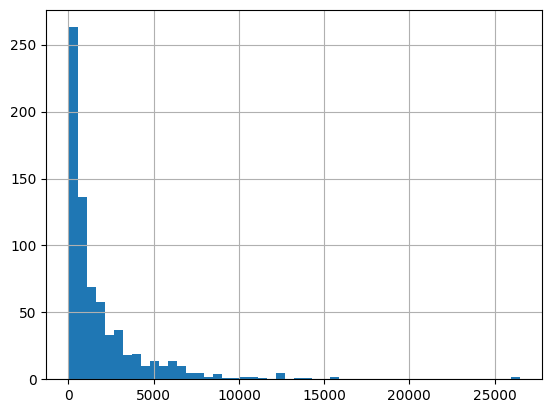

In [91]:
df_risk['risk_text_words_count'].hist(bins=50)
plt.show()

In [114]:
#check how many rows you will get when you do < 1000 words per text
# i will use this
risk_1500 = df_risk[df_risk['risk_text_words_count']<=1500].copy()

In [120]:
risk_1500.head(2)

,cik,paragraph,word_count,year
1,1000228,The health care products distribution industry...,1037,2022
2,1000228,Uncertain global macro-economic and political ...,423,2022


In [116]:
risk_1500 = risk_1500[["cik", "filing_date",'risk_text','risk_text_words_count']].copy()
risk_1500['year'] = pd.to_datetime(risk_1500['filing_date']).dt.year
risk_1500 = risk_1500.drop("filing_date", axis=1).rename({"risk_text_words_count":"word_count", 
                                                          "risk_text":"paragraph"}, 
                                                         axis=1).copy()
risk_1500.head(5)

,cik,paragraph,word_count,year
1,1000228,The health care products distribution industry...,1037,2022
2,1000228,Uncertain global macro-economic and political ...,423,2022
4,1000228,Security risks generally associated with our i...,1240,2022
5,1000697,The Company’s international operations may be ...,592,2022
7,1000697,We may not be able to attract and retain quali...,273,2022


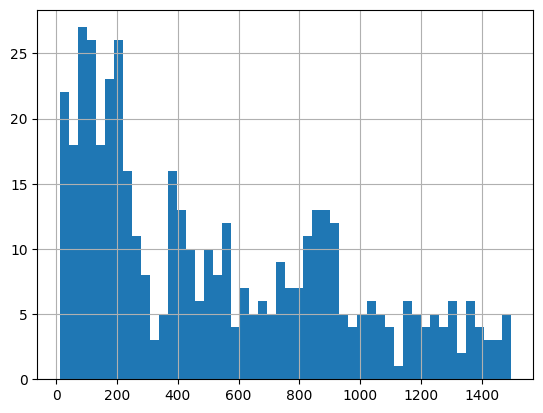

In [121]:
risk_1500['word_count'].hist(bins=50)
plt.show()

In [ ]:
risk_1500[risk_1500.duplicated(['paragraph'], keep=False)]

,cik,paragraph,word_count,year
47,1018724,"We regard our trademarks, service marks, copyr...",407,2022
48,1018724,"The results of operations of, and certain of o...",115,2022
49,1018724,Our Expansion Places a Significant Strain on o...,97,2022
52,1018724,"Because we collect, process, store, and transm...",235,2022
58,1018724,We have a rapidly evolving business model. The...,190,2022
...,...,...,...,...
565,731802,"We are subject to federal, state and local reg...",651,2023
632,899051,We use internally developed and third-party ve...,40,2022
652,899051,We use internally developed and third-party ve...,40,2023
708,947484,•Some of the provisions of our bye-laws and ou...,127,2022


In [133]:
risk_1500 = risk_1500.drop_duplicates(["paragraph"]).copy()
risk_1500

,cik,paragraph,word_count,year
1,1000228,The health care products distribution industry...,1037,2022
2,1000228,Uncertain global macro-economic and political ...,423,2022
4,1000228,Security risks generally associated with our i...,1240,2022
5,1000697,The Company’s international operations may be ...,592,2022
7,1000697,We may not be able to attract and retain quali...,273,2022
...,...,...,...,...
715,947484,The following is a summary description of the ...,904,2023
716,947484,•Adverse developments in the financial markets...,196,2023
717,947484,•The ultimate performance of the Arch MI U.S. ...,117,2023
720,947484,Adverse developments in the financial markets ...,1368,2023


In [154]:
link = Path(__name__).resolve().parent.parent / 'data/risk_paragraphs_unlabeled.csv'
risk_1500.to_csv(link, index=False)